# Determining Predictors of H-1B Salary and Approval (Project *DPH*)

## Project Documentation

**Contributors:**
- Wenhao Yu (netid: *wyu1*)
- Luke Duane (netid: *lduane*)
- Will Badart (netid: *wbadart*)

This project aims to provide meaningful analyses of the factors that drive H-1B visa approval, and provide insightful, tangential analyses which provide business value to enterprises sponsoring H-1B employees. The project has been excecuted for Notre Dame *CSE 40647/ 60647 - Data Science* as specified in the [project instructions](http://www.meng-jiang.com/teaching/CSE647Spring18-Project.pdf).

## Installation

Running the project requires [Python 3](https://www.python.org/downloads/release/python-365/). To install the project to your system as a package, as well as its dependencies, run:

    $ pip3 install git+https://github.com/wbadart/H-1B-Analyzer.git

(Remember the `--user` flag for systems on which you don't have administrative privileges.) This will also add the project's several entry points to your path, for running the individual analyses directly from the command line (see [Usage](#Usage)). Alternatively, if you wish to have access to the complete source of the project, rather than just the source distribution of the package, we recommend installing with the following command:

```
$ git clone https://github.com/wbadart/H-1B-Analyzer.git h1b && cd h1b && pip3 install -e .
```

To uninstall, run:

    $ pip3 uninstall h1b

## Generating the Report

The source code of the report is available under [`docs/main.tex`](./docs/main.tex) if you need to recompile it for any reason (requires full clone of the repo, rather than bare source distribution, as discussed above in [Installation](#Installation)). To compile, simple enter the documentation folder and run `make` (requires `pdflatex` to be installed and available on your `PATH`).

```
$ pwd
/path/to/H-1B-Analyzer
$ cd docs
$ make
```

Otherwise, the complete compiled report is already checked into the repository as [`docs/Determining Predictors of H-1B Salary and Approval.pdf`](./docs/Determining Predictors of H-1B Salary and Approval.pdf).

## Acquiring the Datasets

All the data used from this project is available for free from the Web (see the [final report](./docs/Determining Predictors of H-1B Salary and Approval.pdf), section 5.1 Datasets). It has been collected, archived, and been made available as a bundle at [wbadart.info/data.tar.gz](https://wbadart.info/data.tar.gz).

```
$ wget wbadart.info/data.tar.gz
...
$ tar xzf data.tar.gz
```

This will unpack the `data/` folder into the current directory. Within it will lie all of the pertinent data files expected by the various scripts.

## Usage

All the scripts exposed by this project will read the environment variable `H1B_DATA` to locate the data files described [above](#Acquiring-the-Datasets). Please ensure it is set and accurate before attempting to run any of the scripts.

### Data Description

Much of the initial work in descibing the primary dataset took place in the `h1b.description` submodule. This script can be run to generate a verbose printout of descriptive statistics on different properties of the data, as well as numerous plots of different distributions. The options are listed below:

```
$ h1b.describe --help
usage: h1b.describe [-h] [-f FILE]
                    [-s {totals,salary,employers,positions,year} [{totals,salary,employers,positions,year} ...]]
                    [-p {employers,salary,year} [{employers,salary,year} ...]]
                    [--allstats] [--allplots]

h1b/description2.py Generate descriptive statistics over the primary dataset.
created: MAR 2018

optional arguments:
  -h, --help            show this help message and exit
  -f FILE, --file FILE  location of dataset w/in data directory
                        (default:h1b_kaggle.csv)
  -s {totals,salary,employers,positions,year} [{totals,salary,employers,positions,year} ...], --stats {totals,salary,employers,positions,year} [{totals,salary,employers,positions,year} ...]
                        statistics to generate
  -p {employers,salary,year} [{employers,salary,year} ...], --plots {employers,salary,year} [{employers,salary,year} ...]
                        plots to generate
  --allstats            generate all statistics (overrides -s)
  --allplots            generate all plots (overrides -p)
```

The somewhat opaque descriptions of `--stats` and `--plots` essentially say that you can specify any number of the listed options (e.g. `h1b.describe --stats totals positions`).

### Job Title Clustering

The submodule `h1b.cluster` provides a couple of utilities for clustering the set of job titles within the primary dataset. It also exposes a main execution, made available on the `PATH` as `h1b.cluster`; it can be run as a script as follows:

```
$ h1b.cluster --help
usage: h1b.cluster [-h] [-n CLUSTERS]
                   [--alg {AgglomerativeClustering,KMeans,SpectralClustering}]
                   [-f FILE] [-o OUTPUT]

h1b/cluster.py Find clusterings of the many thousands of job titles within the
dataset. created: APR 2018

optional arguments:
  -h, --help            show this help message and exit
  -n CLUSTERS, --clusters CLUSTERS
                        number of clusters (default:8)
  --alg {AgglomerativeClustering,KMeans,SpectralClustering}
                        clustering algorithm to run (default:KMeans)
  -f FILE, --file FILE  location of dataset w/in data directory
                        (default:h1b_kaggle.csv)
  -o OUTPUT             plot output file (if unset, do not plot, just print
                        clusterings)
```

The most important function this module exports is called `cluster`.

```
$ pydoc h1b.cluster.cluster
Help on function cluster in h1b.cluster:

h1b.cluster.cluster = cluster(algname, n_clusters, data)
    Produce a clustering of the data according to the algorithm's `fit_predict'
    method and the `n_clusters' parameter.
```

Given the name of a clustering algorithm (must be one of `AgglomerativeClustering`, `KMeans`, and `SpectralClustering`, but could be easily expanded to include any clustering algorithm where the number of clusters is fixed as a parameter; raises `RuntimeError` if something other than this provided). For example:

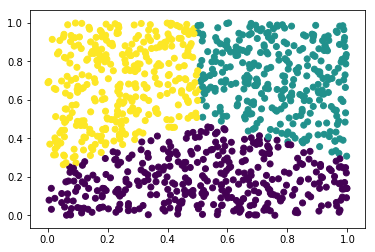

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from h1b.cluster import cluster

data = np.random.random((1000, 2))
clustering = cluster('KMeans', 3, data)
plt.scatter(data[:, 0], data[:, 1], c=clustering)

For this project, the input to the clustering was the set of job titles from the dataset, but a simple list of strings is invlaid input to the clustering algorithms. To solve this, we vectorized the job titles, transforming the list of strings into a sparse matrix of word counts. This structure is very high dimensional (`N_DIM == len(VOCAB)`) which

1. caused a serious slow down in clustering (particularly in `SpectralClustering`)
2. meant it could not be plotted in 2D space

To remedy these, we performed a dimensionality reduction through *SVD*, in a similar fashion to the toy example below. This pipeline is encapsulated in the `cluster_strings` function.

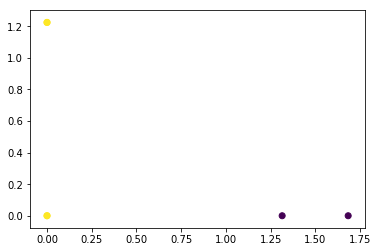

In [2]:
from h1b.cluster import cluster_strings

data = ['CHIEF EXECUTIVE OFFICER', 'CHIEF FINANCIAL OFFICER',
        'IT MANAGER', 'MARKETING MANAGER',
        'DATA ENGINEER', 'SOFTWARE ENGINEER']

svd, clustering = cluster_strings('KMeans', 2, data)
plt.scatter(svd[:, 0], svd[:, 1], c=clustering)

### Classify

The primary data science task we undertook was to classify the certification status of H-1B applications, as a means of informing businesses about important considerations when sponsoring H-1B visas. This functionality is provided by the `h1b.classify` submodule, invokable from the command line as such:

```
$ h1b.classify --help
usage: h1b.classify [-h] [-f FILE]

h1b/classify.py Predict the CASE_STATUS of applications from the primary
dataset. created: MAR 2018

optional arguments:
  -h, --help            show this help message and exit
  -f FILE, --file FILE  location of dataset w/in data directory
                        (default:h1b_kaggle.csv)
```

When run, this program trains a few classifiers (namely, `GaussianNB`, `DecisionTreeClassifier`, and `MLPClassifier`, provided by scikit-learn) and checks their performance over a non-overlapping test subset of the data.